In [1]:
#import tensorflow as tf
import numpy as np
import pandas as pd

In [2]:
# overview of the data
data = pd.read_csv("./dataset/heart.csv")
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
# get a summary of the number of discrete values in each str column
index = [1, 2, 6, 8, 10]
df = np.loadtxt('./dataset/heart.csv', delimiter=',', skiprows=1, usecols = index, dtype = "str")

for i in range(5):
    print("col:", index[i])
    print(pd.Series(df[:, i]).value_counts(), end="\n\n")

col: 1
M    725
F    193
dtype: int64

col: 2
ASY    496
NAP    203
ATA    173
TA      46
dtype: int64

col: 6
Normal    552
LVH       188
ST        178
dtype: int64

col: 8
N    547
Y    371
dtype: int64

col: 10
Flat    460
Up      395
Down     63
dtype: int64



In [4]:
from util import load_data, add_theta_0
from sklearn.preprocessing import StandardScaler

# load data
x = np.loadtxt("./dataset/heart.csv", usecols = range(11), skiprows = 1, dtype = "str", delimiter=',')
y = np.loadtxt("./dataset/heart.csv", usecols = range(11, 12), skiprows = 1, dtype = "str", delimiter=',')


# convert str into int
m, n = x.shape
d0 = {"M": 1, "F": 0}
d1 = {"ASY": 1, "NAP": 2, "ATA": 3, "TA": 4}
d2 = {"Normal": 1, "ST": 2, "LVH": 3}
d3 = {"Y": 1, "N": 0}
d4 = {"Up": 1, "Flat": 2, "Down": 3}
for i in range(m):
    x[i, 1] = d0[x[i, 1]]
    x[i, 2] = d1[x[i, 2]]
    x[i, 6] = d2[x[i, 6]]
    x[i, 8] = d3[x[i, 8]]
    x[i, 10] = d4[x[i, 10]]
    
x = x.astype(float)
y = y.astype(float)

# feature scaling
scaler = StandardScaler().fit(x)
x = scaler.transform(x)

# add intercept
#x = add_theta_0(x)

print("x shape:", x.shape)
print("y shape:", y.shape)

x shape: (918, 11)
y shape: (918,)


In [5]:
# this section contains gbt, which builds a gradient boosted classifier, and its helpers

import math
import sys
import time
from scipy.special import expit

# returns a gradient boosted decision tree classifier (in a form of a list of decision trees)
def gbt(dataset, features, max_depth, treeLength, l_rate, labels):
    y = dataset[:, -1]
    prev_pred = np.full(y.shape[0], math.log(list(y).count(labels[1]) / list(y).count(labels[0])))
    residual = y - prev_pred
    decision_trees = list()
    
    # organize data so its [-1] column contains residuals, [-2]: previous predictions, [-3]: true label
    data = np.append(np.append(dataset, prev_pred.reshape(-1, 1), axis = 1), residual.reshape(-1, 1), axis = 1)

    start = time.time()
    for i in range(treeLength):
        # update progress bar
        sys.stdout.write('\r')
        sys.stdout.write("[%-21s] %d%%  %.2fs    " % 
                         ('='* round(i * 20/treeLength) + ">", 100/treeLength * i, time.time() - start))
        
        # build tree
        tree = build_tree(data, range(dataset.shape[0]), features, max_depth + 1, 0, l_rate, -1)
        decision_trees.append(tree)
    
    # update progress bar to 100%
    sys.stdout.write('\r')
    sys.stdout.write("[%-21s] %d%%   %.2fs    " % ('='* 20 + ">", 100, time.time() - start))  
    
    return decision_trees, math.log(list(y).count(labels[1]) / list(y).count(labels[0]))
                          
                          
# build a decision tree
def build_tree(dataset, index, features, max_depth, depth, l_rate, prev_mse):
    # check if we have reached the maximum depth or there are not no features
    if depth == max_depth or features == 0:
        return
    
    subset = dataset[index, :]
    decision_f, decision_b, decision_groups, min_sub_mse = 0, 0, list(), list()
    min_mse = -1
    
    # loop through all values of each feature to find a decision boundary that minimize the loss after the split
    for f in range(features):
        freq = pd.Series(subset[:, f]).value_counts().to_dict()
        for key, value in freq.items():
            sub_groups= split(dataset, index, key, f) # get the two sub-groups after a split
            mse, sub_mse = get_mse(dataset, sub_groups) # get the weighted mse and a list of mse for sub-groups
            
            # update if the mse is less than the minimum
            if mse < min_mse or min_mse < 0:
                decision_f, decision_b, decision_groups, min_mse, min_sub_mse = f, key, sub_groups, mse, sub_mse
    
    
    left, right = decision_groups
    # fill in attributes of the current node
    root = Node()
    root.feature = decision_f
    root.boundary = decision_b 
    
    # build children of the current node if both left and right children have positive length 
    #     and the weighted mse of sub-groups is less than the mse of the current node
    if len(left) > 0 and len(right) > 0:
        if min_mse < prev_mse or prev_mse < 0:
            root.left = build_tree(dataset, np.array(left), features,max_depth, depth + 1, l_rate, min_sub_mse[0])
            root.right = build_tree(dataset, np.array(right), features,max_depth, depth + 1,l_rate,min_sub_mse[1])
            
    # find the output of the node if we are at a leaf node 
    if not root.left and not root.right:
        residuals = subset[:, -1]
        prev_pred = subset[:, -2]

        root.output = np.sum(residuals) / np.sum(prev_pred.T.dot(np.subtract(1, prev_pred)))
        dataset[index, -2] = expit(np.add(dataset[index, -2], l_rate * root.output))
        dataset[index, -1] = np.subtract(dataset[index, -3], dataset[index, -2])             

    return root

# calculated the weighted MSE of elements of groups and the MSE of each element of groups
def get_mse(dataset, groups):
    length_list = list()
    list_length = sum([len(g) for g in groups])
        
    score_sum = 0
    sub_mse = list()
    for g in groups:
        score = 0
        length = len(g)
        if length != 0:
            y = dataset[g, -1]
            mean = np.full(y.shape, np.mean(y))
            diff = np.subtract(y, mean)
            score = diff.T.dot(diff) / diff.shape[0]
        sub_mse.append(score)
        score_sum += score * (length / list_length)
        
    return score_sum, sub_mse

# split data into two groups based on feature and the decision boundary
#     return two lists consisting of index of the dataset
def split(data, idx, boundary, feature):
    left = np.where(data[idx, feature] < boundary, idx, -1)
    left = left[left >= 0]
    right = np.where(data[idx, feature] >= boundary, idx, -1)
    right = right[right >= 0]

    return left, right


# define class node which stores the decision feature, boundary, left and right subtrees and its label at leaf node 
class Node:
    def __init__(self):
        self.left = None
        self.right = None
        self.feature = 0
        self.boundary = 0
        self.output = 0
        self.pred = 0
        

In [6]:
# this secion contains evaluate function and its helpers

from random import randrange
from statistics import mode

# classify x based on the decision tree at root
def classify(root, x):
    # return the node label if we are at a leaf node
    if not root.left and not root.right:
        return root.output
    
    # go to left or right sub tree based on the value of feature
    if x[root.feature] < root.boundary:
        return classify(root.left, x)
    else:
        return classify(root.right, x)
    
# predict the label of x based on trees, initial_pred, and l_rate
def predict(trees, x, initial_pred, l_rate, treeLength):
    idx = 0
    pred = initial_pred
    
    for i in range(treeLength):
        output = classify(trees[i], x)
        pred += l_rate * output

    return int(expit(pred) > 0.5)

# split dataset into n_folds number of folds
#    all folds have the same number of data and they store index of dataset instead of the original data
def cross_val_split(dataset, n_folds):
    length = data.shape[0]
    set = np.array(range(length))
    fold_size = math.floor(length / n_folds)
    datasets = list()
    
    # random sample each fold one by one
    for i in range(n_folds):
        #print(set.shape)
        idx = np.random.choice(length, size=fold_size, replace=False)
        length -= fold_size
        datasets.append(list(dataset[set[idx]]))
        set = np.delete(set, idx)
        
    return datasets

# evaluate algo by performing (n-fold)-fold cross-validation on dataset
def evaluate(dataset, feature, algo, n_folds, max_depth, treeLength, l_rate, labels):
    folds = cross_val_split(dataset, n_folds)
    scores = list()
    
    for i in range(n_folds):
        # prepare train_set and test_set
        train_set = np.delete(np.array(folds), i, axis=0)
        test_set = np.array(folds[i])
        train_set = train_set.reshape(train_set.shape[0] * train_set.shape[1], train_set.shape[2])
        
        # build gradient boosted decision trees
        trees, initial_pred = algo(train_set, feature, max_depth, treeLength, l_rate, labels)
        
        # calculate accuracy on the train set
        train_predicted = [predict(trees, r[:-1], initial_pred, 0.1, treeLength) for r in train_set]
        train_actual = train_set[:, -1]
        train_accuracy = get_accuracy(np.array(train_actual), np.array(train_predicted))
        sys.stdout.write("train accuracy: %.2f%%    " % (train_accuracy * 100))
        
        # calculate accuracy on the test set
        val_predicted = [predict(trees, r[:-1], initial_pred, 0.1, treeLength) for r in test_set]
        val_actual = test_set[:, -1]
        val_accuracy = get_accuracy(np.array(val_actual), np.array(val_predicted))
        scores.append(val_accuracy)
        sys.stdout.write("val. accuracy: %.2f%%  \n" % (val_accuracy * 100))

    print(scores)
    print("Mean Accuracy:", sum(scores) / len(scores))
    
# return the accuracy (proportaion of data in which predicted matches actual)
def get_accuracy(actual, predicted):
    return 1 - ((actual - predicted).T.dot(actual - predicted) / len(actual))

In [7]:
evaluate(np.append(x, y.reshape(-1, 1), axis=1), x.shape[1], gbt, 10, 3, 10, 0.5, range(2))

[====================>] 100%   3.98s    train accuracy: 88.16%    val. accuracy: 84.62%  
[====================>] 100%   3.95s    train accuracy: 87.06%    val. accuracy: 90.11%  
[====================>] 100%   3.96s    train accuracy: 88.40%    val. accuracy: 87.91%  
[====================>] 100%   3.91s    train accuracy: 88.16%    val. accuracy: 85.71%  
[====================>] 100%   3.96s    train accuracy: 88.16%    val. accuracy: 85.71%  
[====================>] 100%   3.96s    train accuracy: 88.64%    val. accuracy: 84.62%  
[====================>] 100%   3.94s    train accuracy: 88.28%    val. accuracy: 90.11%  
[====================>] 100%   3.96s    train accuracy: 88.16%    val. accuracy: 85.71%  
[====================>] 100%   3.96s    train accuracy: 88.16%    val. accuracy: 82.42%  
[====================>] 100%   4.00s    train accuracy: 88.03%    val. accuracy: 83.52%  
[0.8461538461538461, 0.9010989010989011, 0.8791208791208791, 0.8571428571428572, 0.8571428571428572,

In [10]:
# this sections tries to find the best hyperparameters using the sklearn library
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_validate

# define possible values of hypterparameters
rate = np.array([0.05, 0.1, 0.5, 1])
depth = np.array([3, 4, 5, 6])
n = np.array([10, 50, 100, 200])

mean = list()

# loop trough all combinations of hyperparameters defined above and store their information in mean
for i in range(rate.shape[0]):
    for j in range(depth.shape[0]):
        for k in range(n.shape[0]):
            model = GradientBoostingClassifier(n_estimators=n[k], learning_rate = rate[i], max_depth = depth[j])
            cv = cross_validate(model, x, y, return_train_score=True, cv=10)
            mean.append(np.array([n[k], rate[i], depth[j], np.mean(cv['train_score']), np.mean(cv['test_score'])]))
            

best parameters:   n: 200.0 rate: 0.1 depth: 5.0 train accuracy: 1.0 val. accuracy: 0.8593884376493073


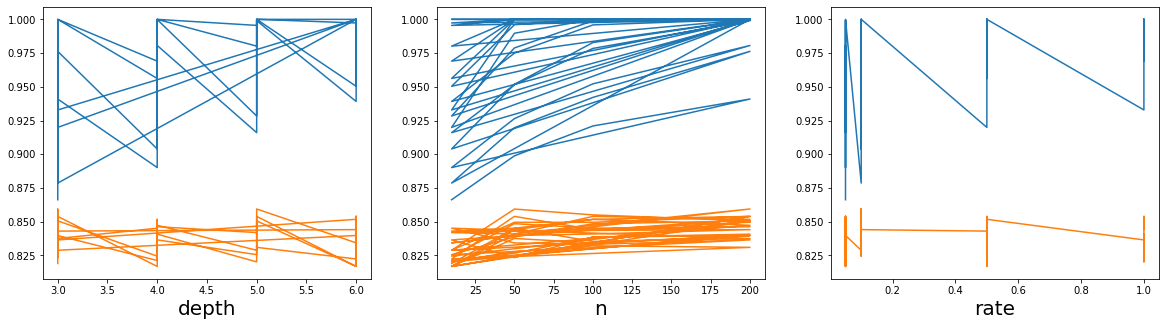

In [11]:
import matplotlib.pyplot as plt

m = np.array(mean)
best = m[np.argmax(m[:, 4])]
print("best parameters:   n:", best[0], "rate:", best[1], "depth:", best[2], "train accuracy:", best[3], 
     "val. accuracy:", best[4])

# print graphs which gives a visual representation of the relationship bewteen each hyperparameter and accuracy
figure, axis = plt.subplots(1, 3)
figure.set_size_inches(20, 5)
axis[0].set_xlabel("depth", fontsize=20)
axis[0].plot(m[:, 2], m[:, 3])
axis[0].plot(m[:, 2], m[:, 4])
axis[1].set_xlabel("n", fontsize=20)
axis[1].plot(m[:, 0], m[:, 3])
axis[1].plot(m[:, 0], m[:, 4])
axis[2].set_xlabel("rate", fontsize=20)
axis[2].plot(m[:, 1], m[:, 3])
axis[2].plot(m[:, 1], m[:, 4])

plt.show()